<a href="https://colab.research.google.com/github/AshkanAlami/RL-ES/blob/main/Evolution_Strategies_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import time
import numpy as np
import math

import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

### Defining the environment and a network. Also, functions for evaluating the agent and rendering it

In [2]:
env = gym.make('CartPole-v1')
env._max_episode_steps = 200
# env = gym.make('LunarLander-v2')


In [3]:
class Net(nn.Module):
    def __init__(self, obs_size, action_size):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)
    
net = Net(env.observation_space.shape[0],env.action_space.n)
print(net)

Net(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)


In [4]:
def evaluate(env, net):
    rewards = 0
    steps = 0
    done = False
    state = env.reset()
    while not done:
        state = torch.FloatTensor([state])
        prob = net(state)
        acts = prob.max(dim=1)[1]
        new_state, reward, done, _ = env.step(acts.data.numpy()[0])
        rewards += reward
        state = new_state
        steps += 1
    
    return rewards, steps

In [5]:
def render_agent(env,net):
    done = False
    state = env.reset()
    while not done:
        env.render()
        state = torch.FloatTensor([state])
        prob = net(state)
        acts = prob.max(dim=1)[1]
        new_state, reward, done, _ = env.step(acts.data.numpy()[0])
        state = new_state
    env.close()

## ($\mu$,$\lambda$)-ES  

### Static 

In [6]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [7]:
def evolution_strategy_V2(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False):

    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)
    best_rewards = np.zeros(num_iters)
    
    population_size = children_size
    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    
    param_size = param_vec[0].size()[0]
    
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
            

        m = R.mean()
             
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        
        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")

    return param_vec, reward_per_iteration, best_rewards

iteration 0, rewards mean: 10.3, best reward: 20.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  import sys


iteration 25, rewards mean: 138.26, best reward: 200.0
iteration 50, rewards mean: 163.58, best reward: 200.0
iteration 75, rewards mean: 181.38, best reward: 200.0
iteration 100, rewards mean: 149.92, best reward: 200.0
iteration 125, rewards mean: 198.0, best reward: 200.0
iteration 150, rewards mean: 163.96, best reward: 200.0
iteration 175, rewards mean: 186.02, best reward: 200.0
iteration 200, rewards mean: 199.0, best reward: 200.0
iteration 225, rewards mean: 190.1, best reward: 200.0
iteration 250, rewards mean: 149.94, best reward: 200.0
iteration 275, rewards mean: 175.66, best reward: 200.0
iteration 300, rewards mean: 189.82, best reward: 200.0
iteration 325, rewards mean: 145.5, best reward: 200.0
iteration 350, rewards mean: 164.5, best reward: 200.0
iteration 375, rewards mean: 168.66, best reward: 200.0
iteration 400, rewards mean: 185.74, best reward: 200.0
iteration 425, rewards mean: 179.28, best reward: 200.0
iteration 450, rewards mean: 182.6, best reward: 200.0
i

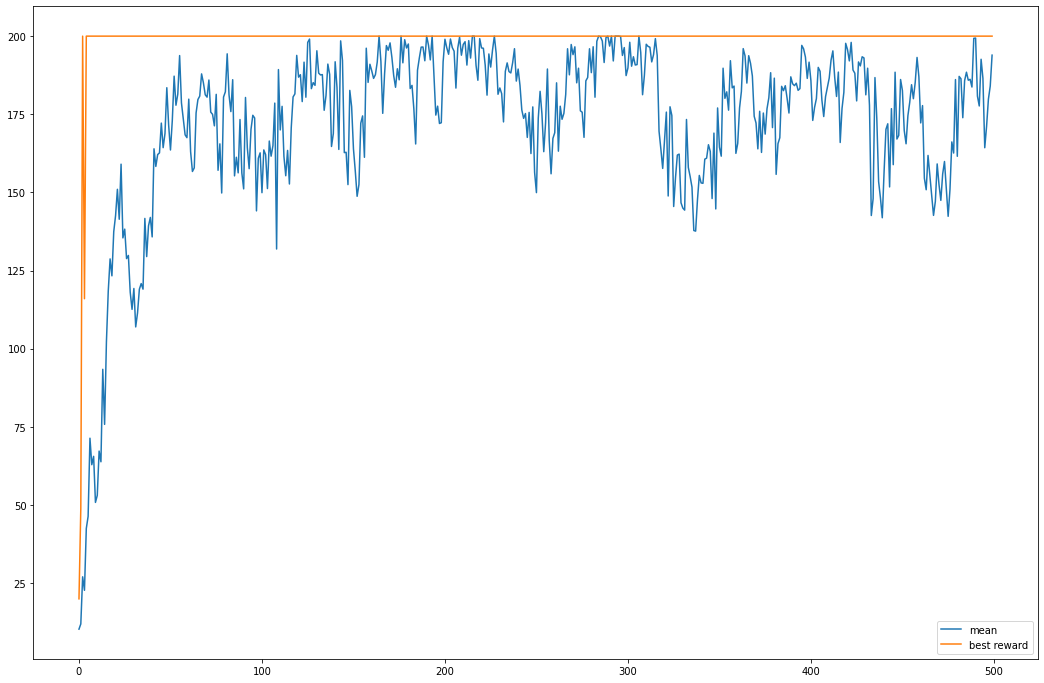

In [8]:
best_params, rewards, best_rewards = evolution_strategy_V2(
    f=evaluate,
    children_size= 10,
    sigma=1,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True,
    
)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()

plt.show()

### Adaptive:  1/5 rule

In [9]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [10]:
def evolution_strategy_V2_adaptive(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False,
    k = 10,
    C = 0.8):
    
    population_size = children_size
    
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)
    best_rewards = np.zeros(num_iters)
    
    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    
    param_size = param_vec[0].size()[0]
    
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
        
        m = R.mean()
             
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
            
        if t % k == 0:
            av_k = (np.array(reward_per_iteration[-k-1:-1])/m).astype('int32').sum()
            if  av_k > 1/5:
                sigma = sigma/C
            elif av_k < 1/5:
                sigma = sigma*C

    return param_vec, reward_per_iteration, best_rewards

iteration 0, rewards mean: 9.5, best reward: 11.0
iteration 25, rewards mean: 170.24, best reward: 200.0
iteration 50, rewards mean: 184.66, best reward: 200.0
iteration 75, rewards mean: 197.82, best reward: 200.0
iteration 100, rewards mean: 197.9, best reward: 200.0
iteration 125, rewards mean: 195.62, best reward: 200.0
iteration 150, rewards mean: 200.0, best reward: 200.0
iteration 175, rewards mean: 193.48, best reward: 200.0
iteration 200, rewards mean: 195.68, best reward: 200.0
iteration 225, rewards mean: 200.0, best reward: 200.0
iteration 250, rewards mean: 197.76, best reward: 200.0
iteration 275, rewards mean: 197.8, best reward: 200.0
iteration 300, rewards mean: 197.82, best reward: 200.0
iteration 325, rewards mean: 197.84, best reward: 200.0
iteration 350, rewards mean: 193.32, best reward: 200.0
iteration 375, rewards mean: 197.72, best reward: 200.0
iteration 400, rewards mean: 197.82, best reward: 200.0
iteration 425, rewards mean: 193.4, best reward: 200.0
iterat

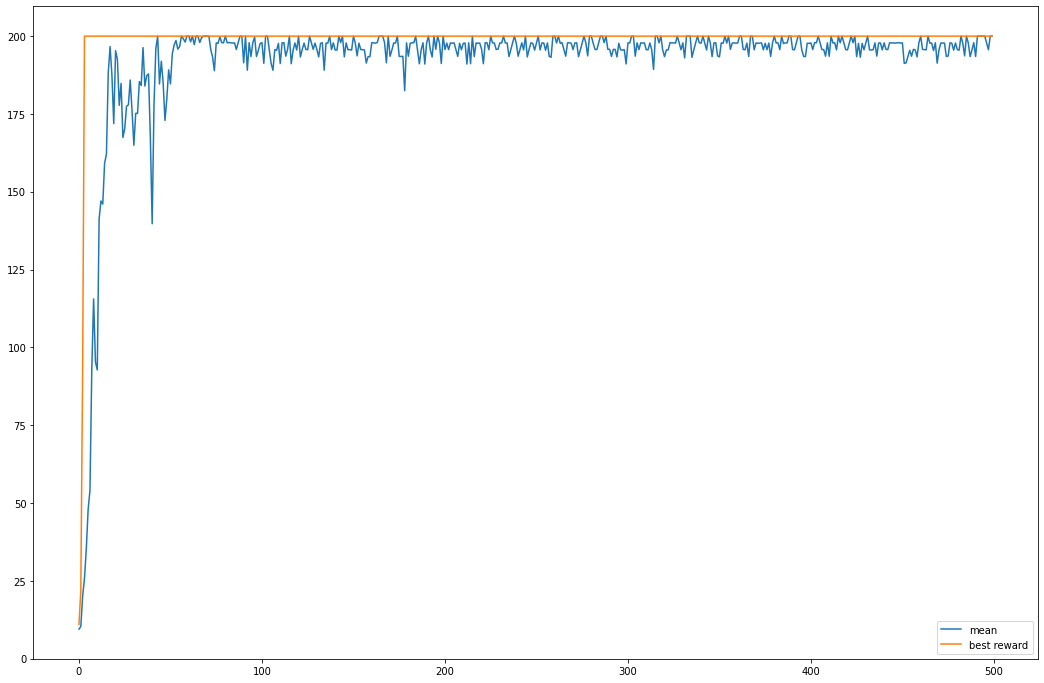

In [11]:
best_params, rewards, best_rewards = evolution_strategy_V2_adaptive(
    f=evaluate,
    children_size= 10,
    sigma=0.1,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True,
    k = 5
    
)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [12]:
# render_agent(env, net)

### self-adaptive single $\sigma$

In [13]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [14]:
def evolution_strategy_V2_self_adaptive_one_sigma(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    
    population_size = children_size
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    best_rewards = np.zeros(num_iters)

    param_size = param_vec[0].size()[0]
    lr = (1/math.sqrt(param_size))
    print("lr" , lr)
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                

        m = R.mean()
             
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
        sigma = sigma * math.exp(lr * np.random.randn())
        if sigma < 0.005:
            sigma = 0.005    


    return param_vec, reward_per_iteration, best_rewards

lr 0.01052573266254254
iteration 0, rewards mean: 16.6, best reward: 72.0
iteration 25, rewards mean: 133.92, best reward: 200.0
iteration 50, rewards mean: 146.68, best reward: 200.0
iteration 75, rewards mean: 147.84, best reward: 200.0
iteration 100, rewards mean: 139.24, best reward: 200.0
iteration 125, rewards mean: 174.42, best reward: 200.0
iteration 150, rewards mean: 176.38, best reward: 200.0
iteration 175, rewards mean: 163.44, best reward: 200.0
iteration 200, rewards mean: 163.6, best reward: 200.0
iteration 225, rewards mean: 172.0, best reward: 200.0
iteration 250, rewards mean: 178.68, best reward: 200.0
iteration 275, rewards mean: 170.44, best reward: 200.0
iteration 300, rewards mean: 171.18, best reward: 200.0
iteration 325, rewards mean: 197.62, best reward: 200.0
iteration 350, rewards mean: 191.4, best reward: 200.0
iteration 375, rewards mean: 198.74, best reward: 200.0
iteration 400, rewards mean: 186.88, best reward: 200.0
iteration 425, rewards mean: 159.38,

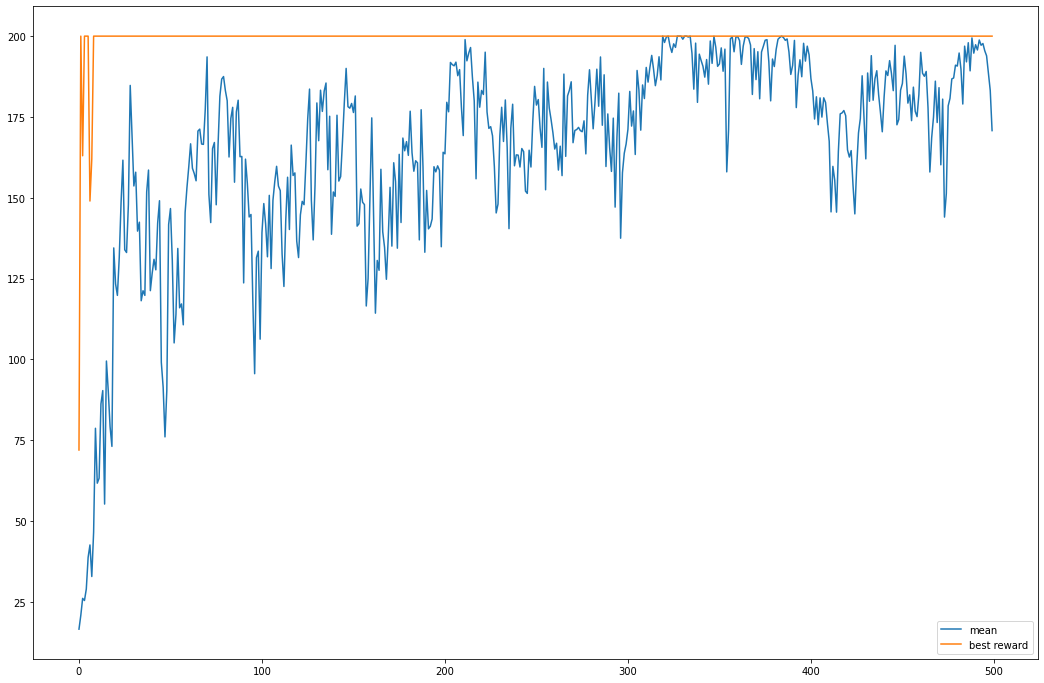

In [15]:
best_params, rewards, best_rewards = evolution_strategy_V2_self_adaptive_one_sigma(
    f=evaluate,
    children_size= 10,
    sigma=0.8,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True

)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [16]:
# render_agent(env, net)

### Self-adaptive multiple $\sigma$

In [17]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [18]:
def evolution_strategy_V2_self_adaptive_multiple_sigma(
    f,
    children_size,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    
    population_size = children_size
    # assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    best_rewards = np.zeros(num_iters)

    param_size = param_vec[0].size()[0]
    glr = 1/math.sqrt(param_size*2)
    cwlr = 1/math.sqrt(2*math.sqrt(param_size))
    sigmas = abs(np.random.randn(param_size))
    
    print("glr" , glr, "cwlr", cwlr)  
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
#         N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size ) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i].detach().numpy() + sigmas *N[i][j]
                params_try = torch.from_numpy(params_try.astype(np.float32))
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1


        m = R.mean()

        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
    
        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigmas * NN[i])


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()
        best_rewards[t] = max(R)

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
        for j in range(param_size):
            
            sigmas[j] = sigmas[j] * math.exp(glr * np.random.randn() *0.5 + cwlr * np.random.randn() * 0.5)
            
            if sigmas[j] < 0.005:
                sigmas[j] = 0.005 


    return param_vec, reward_per_iteration, best_rewards

glr 0.007442816942640563 cwlr 0.07254561552065893
iteration 0, rewards mean: 15.6, best reward: 33.0
iteration 25, rewards mean: 127.02, best reward: 200.0
iteration 50, rewards mean: 108.06, best reward: 200.0
iteration 75, rewards mean: 148.6, best reward: 200.0
iteration 100, rewards mean: 126.6, best reward: 200.0
iteration 125, rewards mean: 165.3, best reward: 200.0
iteration 150, rewards mean: 188.28, best reward: 200.0
iteration 175, rewards mean: 173.84, best reward: 200.0
iteration 200, rewards mean: 176.34, best reward: 200.0
iteration 225, rewards mean: 174.74, best reward: 200.0
iteration 250, rewards mean: 172.74, best reward: 200.0
iteration 275, rewards mean: 158.06, best reward: 200.0
iteration 300, rewards mean: 170.1, best reward: 200.0
iteration 325, rewards mean: 170.12, best reward: 200.0
iteration 350, rewards mean: 163.68, best reward: 200.0
iteration 375, rewards mean: 174.06, best reward: 200.0
iteration 400, rewards mean: 167.52, best reward: 200.0
iteration 

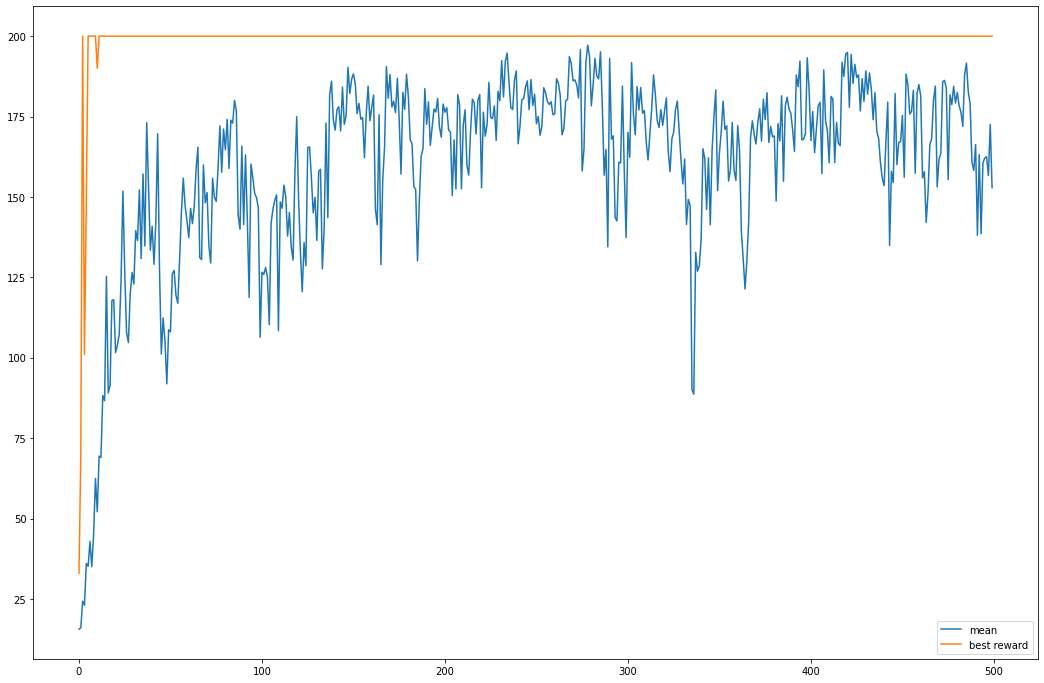

In [19]:
best_params, rewards, best_rewards = evolution_strategy_V2_self_adaptive_multiple_sigma(
    f=evaluate,
    children_size= 10,
    num_iters=500,
    net=net, 
    parent_size= 5,
    print_reward = True)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [20]:
# render_agent(env, net)

## ($\mu$+$\lambda$)-ES

### Static

In [21]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [22]:
def evolution_strategy_V2(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    population_size = children_size
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)
    best_rewards = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    
    param_size = param_vec[0].size()[0]
    
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size + 1)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size +1) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                
            #add parent to list 
            nn.utils.vector_to_parameters(param_vec[i], net.parameters())
            R[index_counter], _ = f(env,net)
            parent_indx[index_counter] = i
            NN.append(torch.from_numpy(np.array([0]).astype(np.float32)))
            index_counter += 1
            
        m = R.mean()

        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()
                
        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")

    return param_vec, reward_per_iteration, best_rewards

iteration 0, rewards mean: 11.454545454545455, best reward: 36.0
iteration 25, rewards mean: 100.54545454545455, best reward: 200.0
iteration 50, rewards mean: 132.47272727272727, best reward: 200.0
iteration 75, rewards mean: 141.8, best reward: 200.0
iteration 100, rewards mean: 168.29090909090908, best reward: 200.0
iteration 125, rewards mean: 171.16363636363636, best reward: 200.0
iteration 150, rewards mean: 156.4181818181818, best reward: 200.0
iteration 175, rewards mean: 161.8, best reward: 200.0
iteration 200, rewards mean: 174.65454545454546, best reward: 200.0
iteration 225, rewards mean: 166.4909090909091, best reward: 200.0
iteration 250, rewards mean: 141.5090909090909, best reward: 200.0
iteration 275, rewards mean: 181.63636363636363, best reward: 200.0
iteration 300, rewards mean: 163.5818181818182, best reward: 200.0
iteration 325, rewards mean: 172.85454545454544, best reward: 200.0
iteration 350, rewards mean: 157.12727272727273, best reward: 200.0
iteration 375, r

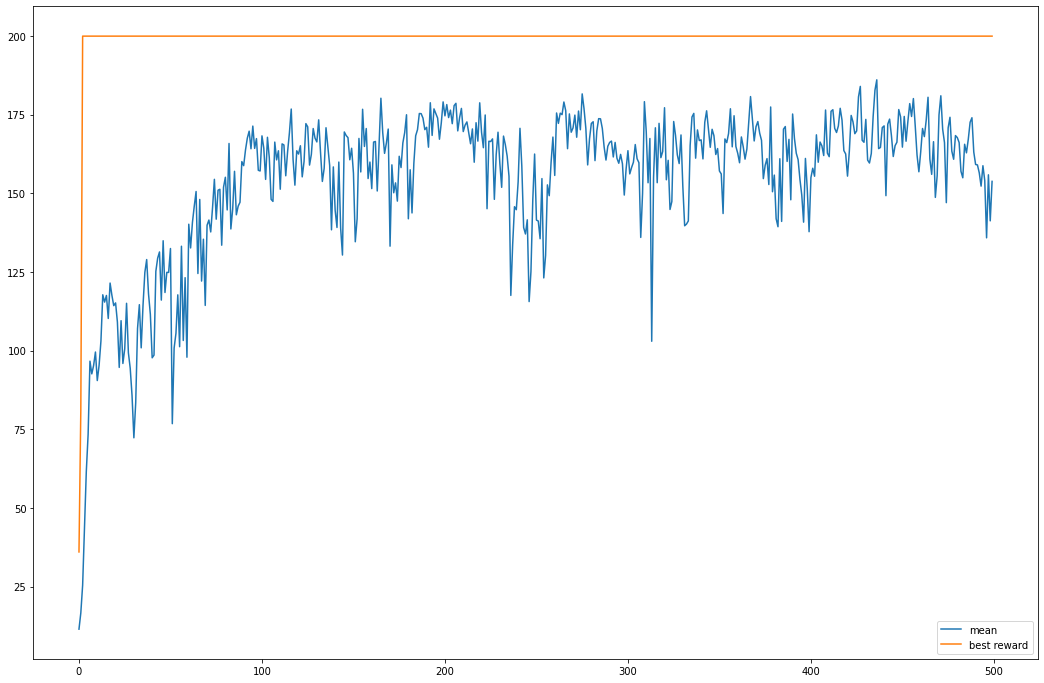

In [23]:
best_params, rewards, best_rewards = evolution_strategy_V2(
    f=evaluate,
    children_size= 10,
    sigma=0.1,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True,
    
)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [24]:
# render_agent(env, net)

### Adaptive: 1/5 rule

In [25]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [26]:
def evolution_strategy_V2_adaptive(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False,
    k = 10,
    C = 0.8):
    
    population_size = children_size
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)
    best_rewards = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    
    param_size = param_vec[0].size()[0]
    
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size + 1)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size +1) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                
            #add parent to list 
            nn.utils.vector_to_parameters(param_vec[i], net.parameters())
            R[index_counter], _ = f(env,net)
            parent_indx[index_counter] = i
            NN.append(torch.from_numpy(np.array([0]).astype(np.float32)))
            index_counter += 1
        

        m = R.mean()
        
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
            
        if t % k == 0:
            av_k = (np.array(reward_per_iteration[-k-1:-1])/m).astype('int32').sum()
            if  av_k > 1:
                sigma = sigma/C
            elif av_k < 1:
                sigma = sigma*C

    return param_vec, reward_per_iteration, best_rewards

iteration 0, rewards mean: 10.727272727272727, best reward: 22.0
iteration 25, rewards mean: 158.4909090909091, best reward: 200.0
iteration 50, rewards mean: 192.4, best reward: 200.0
iteration 75, rewards mean: 200.0, best reward: 200.0
iteration 100, rewards mean: 200.0, best reward: 200.0
iteration 125, rewards mean: 200.0, best reward: 200.0
iteration 150, rewards mean: 200.0, best reward: 200.0
iteration 175, rewards mean: 199.98181818181817, best reward: 200.0
iteration 200, rewards mean: 200.0, best reward: 200.0
iteration 225, rewards mean: 200.0, best reward: 200.0
iteration 250, rewards mean: 200.0, best reward: 200.0
iteration 275, rewards mean: 200.0, best reward: 200.0
iteration 300, rewards mean: 200.0, best reward: 200.0
iteration 325, rewards mean: 200.0, best reward: 200.0
iteration 350, rewards mean: 200.0, best reward: 200.0
iteration 375, rewards mean: 200.0, best reward: 200.0
iteration 400, rewards mean: 200.0, best reward: 200.0
iteration 425, rewards mean: 200.

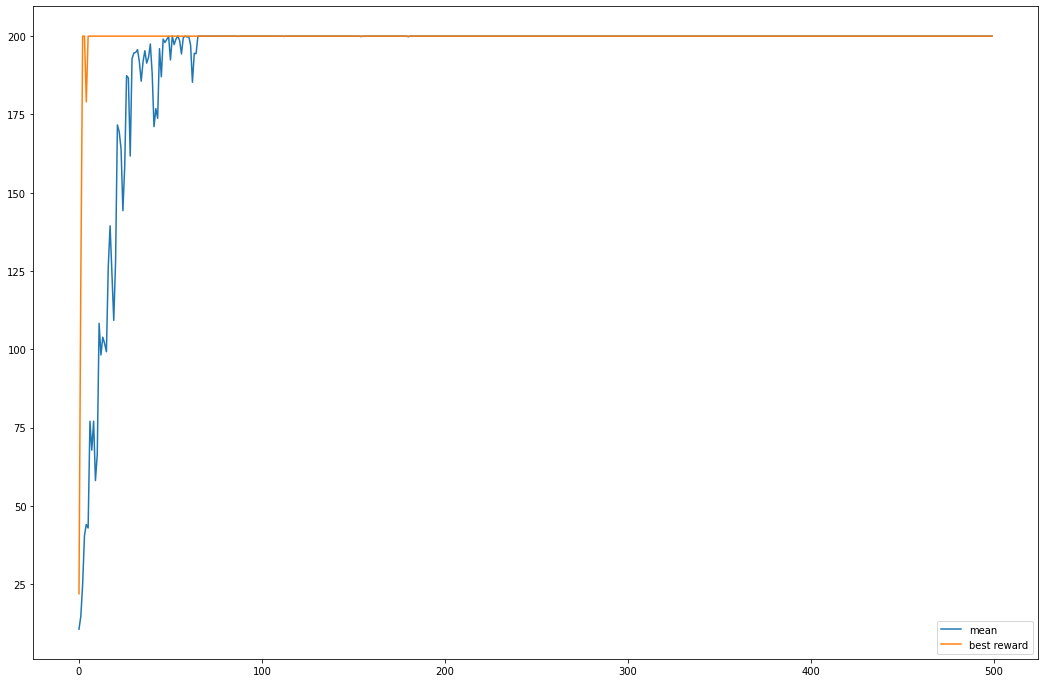

In [27]:
best_params, rewards, best_rewards = evolution_strategy_V2_adaptive(
    f=evaluate,
    children_size= 10,
    sigma=0.9,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True,
    k = 5
    
)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [28]:
# render_agent(env, net)

### self-adaptive single $\sigma$

In [29]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [30]:
def evolution_strategy_V2_self_adaptive_one_sigma(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    
    population_size = children_size
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    best_rewards = np.zeros(num_iters)

    param_size = param_vec[0].size()[0]
    #parent_indx = []
    lr = (1/math.sqrt(param_size))
    print("lr" , lr)
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size + 1)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size +1) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                
            #add parent to list 
            nn.utils.vector_to_parameters(param_vec[i], net.parameters())
            R[index_counter], _ = f(env,net)
            parent_indx[index_counter] = i
            NN.append(torch.from_numpy(np.array([0]).astype(np.float32)))
            index_counter += 1

        m = R.mean()

        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
        sigma = sigma * math.exp(lr * np.random.randn())
        if sigma < 0.005:
            sigma = 0.005    


    return param_vec, reward_per_iteration, best_rewards

lr 0.01052573266254254
iteration 0, rewards mean: 11.454545454545455, best reward: 21.0
iteration 25, rewards mean: 100.14545454545454, best reward: 200.0
iteration 50, rewards mean: 137.85454545454544, best reward: 200.0
iteration 75, rewards mean: 151.27272727272728, best reward: 200.0
iteration 100, rewards mean: 170.8909090909091, best reward: 200.0
iteration 125, rewards mean: 168.25454545454545, best reward: 200.0
iteration 150, rewards mean: 183.56363636363636, best reward: 200.0
iteration 175, rewards mean: 178.92727272727274, best reward: 200.0
iteration 200, rewards mean: 190.1090909090909, best reward: 200.0
iteration 225, rewards mean: 179.70909090909092, best reward: 200.0
iteration 250, rewards mean: 175.8, best reward: 200.0
iteration 275, rewards mean: 171.5090909090909, best reward: 200.0
iteration 300, rewards mean: 175.4909090909091, best reward: 200.0
iteration 325, rewards mean: 162.07272727272726, best reward: 200.0
iteration 350, rewards mean: 183.56363636363636,

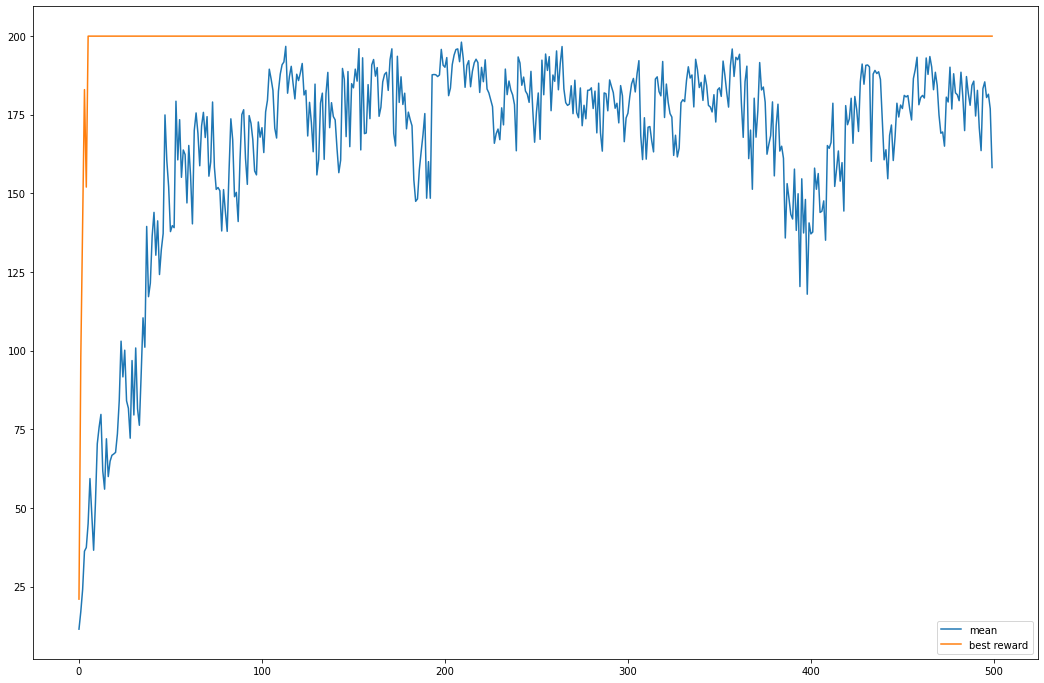

In [31]:
best_params, rewards, best_rewards = evolution_strategy_V2_self_adaptive_one_sigma(
    f=evaluate,
    children_size= 10,
    sigma=0.8,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True

)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [32]:
# render_agent(env, net)

### Self-adaptive multiple $\sigma$

In [33]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [34]:
def evolution_strategy_V2_self_adaptive_multiple_sigma(
    f,
    children_size,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    
    population_size = children_size
    # assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    best_rewards = np.zeros(num_iters)

    param_size = param_vec[0].size()[0]
    glr = 1/math.sqrt(param_size*2)
    cwlr = 1/math.sqrt(2*math.sqrt(param_size))
    sigmas = abs(np.random.randn(param_size))
    
    print("glr" , glr, "cwlr", cwlr)  
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
#         N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size + 1)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size +1) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i].detach().numpy() + sigmas *N[i][j]
                params_try = torch.from_numpy(params_try.astype(np.float32))
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                
            #add parent to list 
            nn.utils.vector_to_parameters(param_vec[i], net.parameters())
            R[index_counter], _ = f(env,net)
            parent_indx[index_counter] = i
            NN.append(np.array([0]))
            index_counter += 1

        m = R.mean()
             
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
    
        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigmas * NN[i])


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()
        best_rewards[t] = max(R)

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
        for j in range(param_size):
            
            sigmas[j] = sigmas[j] * math.exp(glr * np.random.randn() *0.5 + cwlr * np.random.randn() * 0.5)
            
            if sigmas[j] < 0.005:
                sigmas[j] = 0.005 


    return param_vec, reward_per_iteration, best_rewards

glr 0.007442816942640563 cwlr 0.07254561552065893
iteration 0, rewards mean: 20.636363636363637, best reward: 70.0
iteration 25, rewards mean: 76.9090909090909, best reward: 200.0
iteration 50, rewards mean: 111.94545454545455, best reward: 200.0
iteration 75, rewards mean: 132.36363636363637, best reward: 200.0
iteration 100, rewards mean: 114.25454545454545, best reward: 200.0
iteration 125, rewards mean: 154.6, best reward: 200.0
iteration 150, rewards mean: 151.07272727272726, best reward: 200.0
iteration 175, rewards mean: 156.23636363636365, best reward: 200.0
iteration 200, rewards mean: 150.70909090909092, best reward: 200.0
iteration 225, rewards mean: 143.96363636363637, best reward: 200.0
iteration 250, rewards mean: 141.03636363636363, best reward: 200.0
iteration 275, rewards mean: 165.2, best reward: 200.0
iteration 300, rewards mean: 104.9090909090909, best reward: 200.0
iteration 325, rewards mean: 171.72727272727272, best reward: 200.0
iteration 350, rewards mean: 155.

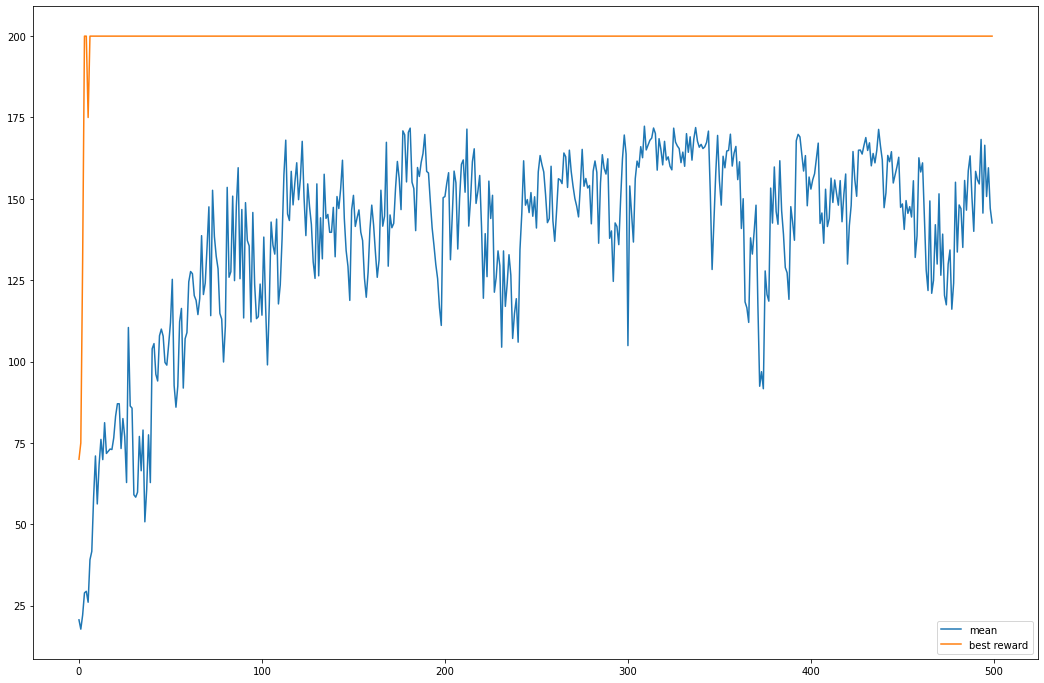

In [35]:
best_params, rewards, best_rewards = evolution_strategy_V2_self_adaptive_multiple_sigma(
    f=evaluate,
    children_size= 10,
    num_iters=500,
    net=net, 
    parent_size= 5,
    print_reward = True)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [38]:
# render_agent(env, net)